In [115]:
#Importing Libraries for ML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


import warnings
warnings.filterwarnings("ignore")


In [116]:
# Importing Data

df = pd.read_csv('heart_disease_prediction.csv')
df

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,Absence
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,Absence
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,Absence
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,Absence


In [117]:
df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


In [118]:
df.isnull().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

## 2. Handling Categorical Data 

In [119]:
df["Heart Disease"] = df["Heart Disease"].map({"Absence":0, "Presence":1})
df.head(3)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1


## 3. Remove Outliers

In [120]:
def plot_distribution(df, col):
    fig, ax =plt.subplots(1,2)
    plt.figure(figsize=(40,10))
    sns.distplot(df[col], ax=ax[0])  
    df.boxplot(column=col, ax=ax[1])
    plt.show()

def find_outliers_normal(data, col):
    upper_bound = data[col].mean() + 3*data[col].std()
    lower_bound = data[col].mean() - 3*data[col].std()

    upper_outliers = len(data.loc[data[col]>upper_bound])
    lower_outliers = len(data.loc[data[col]>upper_bound])
    
    print("Outliers in '",col,"' Column")
    print("Upper Bound - ",upper_bound)
    print("Lower Bound - ",lower_bound)
    print("Number of Upper Outliers - ",upper_outliers)
    print("Number of Lower Outliers - ",lower_outliers)
    print("")
    
def find_outliers_skewed(df, col):
    IQR = df[col].quantile(0.75)-df[col].quantile(0.25)
    
    upper_bound = df[col].quantile(0.75) + (IQR*1.5)
    lower_bound = df[col].quantile(0.25) - (IQR*1.5)
    
    upper_outliers = len(df.loc[df[col]>upper_bound])
    lower_outliers = len(df.loc[df[col]<lower_bound])
    
    
    print("Outliers in '",col,"' Column")
    print("Upper Bound - ",upper_bound)
    print("Lower Bound - ",lower_bound)
    print("Number of Upper Outliers - ",upper_outliers)
    print("Number of Lower Outliers - ",lower_outliers)
    print("")


def remove_outliers_normal(df, col):
    df = df.copy(deep=True)
    upper_bound = df[col].mean() + 3*df[col].std()
    lower_bound = df[col].mean() - 3*df[col].std()
    
    df.loc[df[col]>=upper_bound, col] = upper_bound
    df.loc[df[col]<=lower_bound, col] = lower_bound
    
    return df

def remove_outliers_skewed(df, col):
    IQR = df[col].quantile(0.75)-df[col].quantile(0.25)
    
    upper_bridge = df[col].quantile(0.75) + (IQR*1.5)
    lower_bridge = df[col].quantile(0.25) - (IQR*1.5)
    
    df.loc[df[col]>=upper_bridge, col] = upper_bridge
    df.loc[df[col]<=lower_bridge, col] = lower_bridge
    
    return df

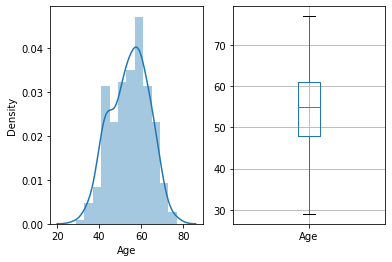

<Figure size 2880x720 with 0 Axes>

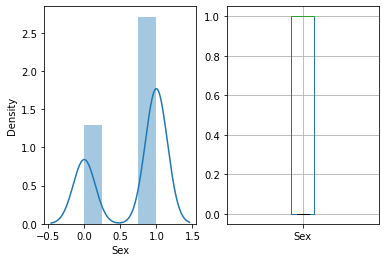

<Figure size 2880x720 with 0 Axes>

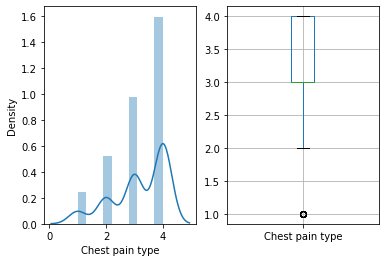

<Figure size 2880x720 with 0 Axes>

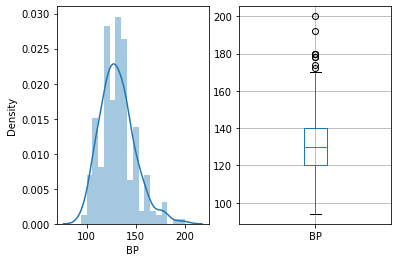

<Figure size 2880x720 with 0 Axes>

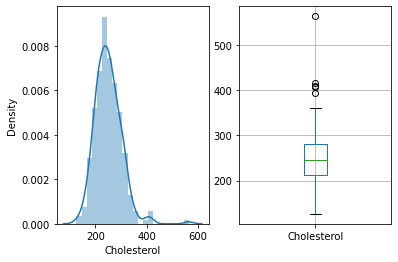

<Figure size 2880x720 with 0 Axes>

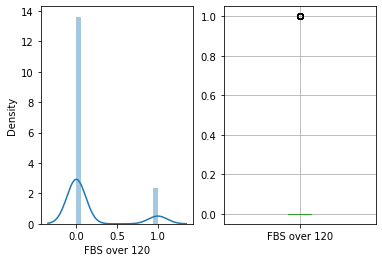

<Figure size 2880x720 with 0 Axes>

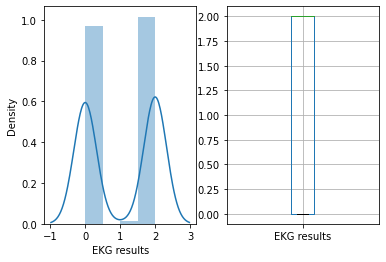

<Figure size 2880x720 with 0 Axes>

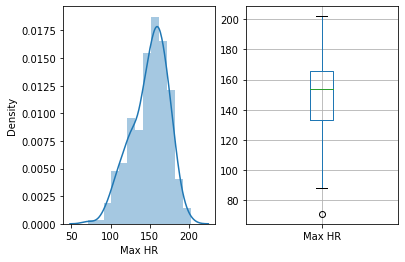

<Figure size 2880x720 with 0 Axes>

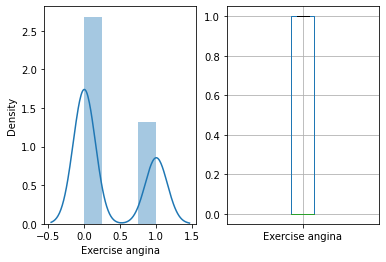

<Figure size 2880x720 with 0 Axes>

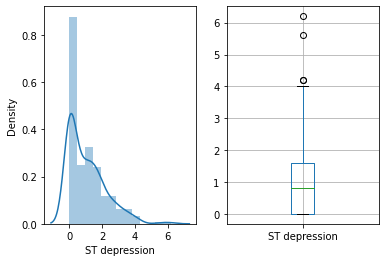

<Figure size 2880x720 with 0 Axes>

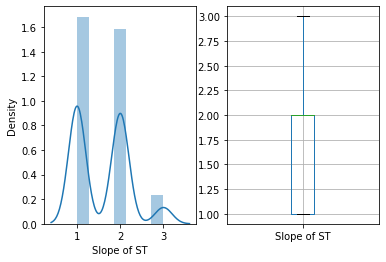

<Figure size 2880x720 with 0 Axes>

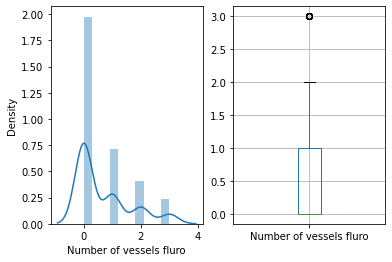

<Figure size 2880x720 with 0 Axes>

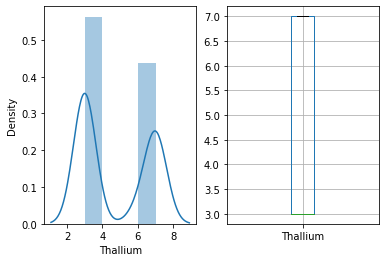

<Figure size 2880x720 with 0 Axes>

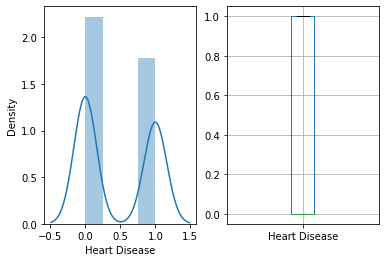

<Figure size 2880x720 with 0 Axes>

In [121]:
feature_list = df.columns

for i in feature_list:
    plot_distribution(df, i)

In [122]:
normally_dist_features = ["BP", "Cholesterol", "Max HR"]

skewed_dist_features = ["ST depression"]

In [123]:
# Normally distributed features
print("Outliers before")
for i in normally_dist_features:
    find_outliers_normal(df, i)

Outliers before
Outliers in ' BP ' Column
Upper Bound -  184.929269322847
Lower Bound -  77.75961956604186
Number of Upper Outliers -  2
Number of Lower Outliers -  2

Outliers in ' Cholesterol ' Column
Upper Bound -  404.717970608553
Lower Bound -  94.60054790996554
Number of Upper Outliers -  4
Number of Lower Outliers -  4

Outliers in ' Max HR ' Column
Upper Bound -  219.17492810313806
Lower Bound -  80.1806274524175
Number of Upper Outliers -  0
Number of Lower Outliers -  0



In [124]:
# Remove outliers in normally distributed features
for i in normally_dist_features:
    df = remove_outliers_normal(df, i)
    

In [125]:
print("Outliers after")
for i in normally_dist_features:
    find_outliers_normal(df, i)

Outliers after
Outliers in ' BP ' Column
Upper Bound -  184.0128940309537
Lower Bound -  78.51198403308848
Number of Upper Outliers -  2
Number of Lower Outliers -  2

Outliers in ' Cholesterol ' Column
Upper Bound -  395.06937827131094
Lower Bound -  102.92967270968319
Number of Upper Outliers -  4
Number of Lower Outliers -  4

Outliers in ' Max HR ' Column
Upper Bound -  218.8806333866948
Lower Bound -  80.5429268166564
Number of Upper Outliers -  0
Number of Lower Outliers -  0



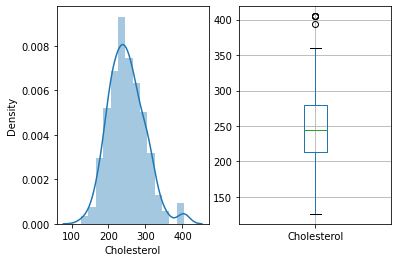

<Figure size 2880x720 with 0 Axes>

In [126]:
plot_distribution(df, "Cholesterol")

# Feature Selection
- Heatmap shows that their are no two features which are correlated.
- "FBS over 120" column is having least correlation with Target variable hence we drop it.

<AxesSubplot:>

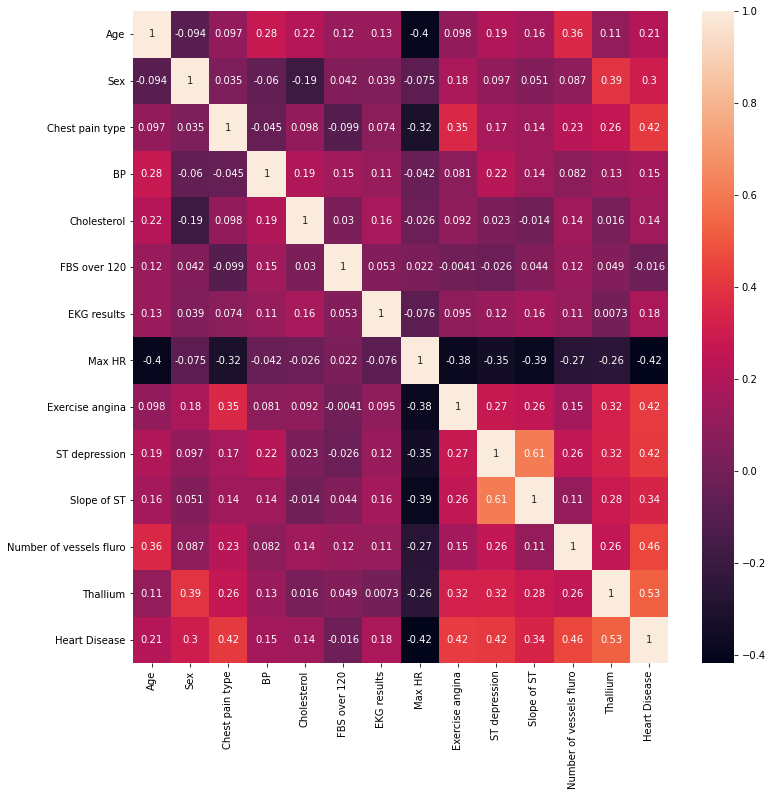

In [127]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)

In [128]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

select_feature = SelectKBest(score_func = chi2, k="all")

features = select_feature.fit(x, y)

features_df = pd.DataFrame(x.columns, columns=["Features"])
scores_df = pd.DataFrame(features.scores_, columns=["Scores"])

feature_scores_df = pd.concat([features_df, scores_df], axis=1)

feature_scores_df.sort_values(by="Scores", ascending=False)

,Features,Scores
7,Max HR,167.567130
11,Number of vessels fluro,74.122652
12,Thallium,59.463091
9,ST depression,58.697286
4,Cholesterol,47.662596
8,Exercise angina,31.822472
0,Age,18.485273
3,BP,14.757895
2,Chest pain type,13.330455
6,EKG results,8.688587


In [129]:
df.drop(["FBS over 120","EKG results", "Sex", "Slope of ST"], axis=1, inplace=True)
df.head(3)

,Age,Chest pain type,BP,Cholesterol,Max HR,Exercise angina,ST depression,Number of vessels fluro,Thallium,Heart Disease
0,70,4,130.0,322.000000,109.0,0,2.4,3,3,1
1,67,3,115.0,404.717971,160.0,0,1.6,0,7,0
2,57,2,124.0,261.000000,141.0,0,0.3,0,7,1


# Standerdization and Normalization of Data

In [130]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)

x_test  = scaler.transform(x_test)

# Split Data

## Split into Features and Target

In [131]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

## Split into Train and Test

In [132]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0 )

# KNN Classifier

In [133]:
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(x_train,y_train)

y_pred = knn.predict(x_test)

In [134]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.60      0.60      0.60        10

    accuracy                           0.70        27
   macro avg       0.68      0.68      0.68        27
weighted avg       0.70      0.70      0.70        27



In [135]:
confusion_matrix(y_test, y_pred)

array([[13,  4],
       [ 4,  6]], dtype=int64)

In [136]:
accuracy_score(y_test, y_pred)

0.7037037037037037

# SVM Classifier

In [137]:
svc = SVC()

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

In [138]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.82      0.76        17
           1       0.57      0.40      0.47        10

    accuracy                           0.67        27
   macro avg       0.64      0.61      0.61        27
weighted avg       0.65      0.67      0.65        27



In [139]:
confusion_matrix(y_test, y_pred)

array([[14,  3],
       [ 6,  4]], dtype=int64)

In [140]:
accuracy_score(y_test, y_pred)

0.6666666666666666

# RandomForest Classifier

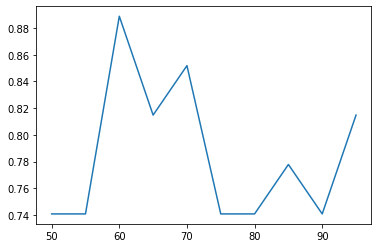

In [141]:
scores = []

for i in range(50,100,5):
    model = RandomForestClassifier(n_estimators=i)
    model.fit(x_train,y_train)
    scores.append(model.score(x_test,y_test))

plt.plot(range(50,100,5), scores)
plt.show()

In [162]:
model = RandomForestClassifier(n_estimators=60, n_jobs=-1, random_state=42)

model.fit(x_train,y_train)

RandomForestClassifier(n_estimators=60, n_jobs=-1, random_state=42)

In [163]:
params = {'max_features': range(1,11), 'min_samples_leaf': range(1,3),'max_depth': range(3,13), 'criterion':['gini','entropy']}  

model_cv = GridSearchCV(model, params, refit=True, verbose=3, n_jobs=-1, )

model_cv.fit(x_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(estimator=RandomForestClassifier(n_estimators=60, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(3, 13),
                         'max_features': range(1, 11),
                         'min_samples_leaf': range(1, 3)},
             verbose=3)

In [164]:
y_pred = model_cv.predict(x_test)

In [165]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.64      0.70      0.67        10

    accuracy                           0.74        27
   macro avg       0.72      0.73      0.73        27
weighted avg       0.75      0.74      0.74        27



In [166]:
confusion_matrix(y_test, y_pred)

array([[13,  4],
       [ 3,  7]], dtype=int64)

In [167]:
accuracy_score(y_test, y_pred)

0.7407407407407407

# XGBoost Classifier

In [148]:
xgb = XGBClassifier()

xgb.fit(x_train, y_train)

[12:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [149]:
y_pred = xgb.predict(x_test)

In [150]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       0.67      0.80      0.73        10

    accuracy                           0.78        27
   macro avg       0.77      0.78      0.77        27
weighted avg       0.79      0.78      0.78        27



In [151]:
confusion_matrix(y_test, y_pred)

array([[13,  4],
       [ 2,  8]], dtype=int64)

In [152]:
accuracy_score(y_test, y_pred)

0.7777777777777778

### Hyperparameter Optimization with HyperOpt

In [153]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

In [154]:
space={ 'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'n_estimators': hp.quniform('min_child_weight', 100, 2000, 20),
        'seed': 0
      }
space

{'max_depth': <hyperopt.pyll.base.Apply at 0x1a750e03070>,
 'gamma': <hyperopt.pyll.base.Apply at 0x1a750e03ee0>,
 'reg_alpha': <hyperopt.pyll.base.Apply at 0x1a750e039d0>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x1a750e03670>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x1a750e15790>,
 'n_estimators': <hyperopt.pyll.base.Apply at 0x1a750e15310>,
 'seed': 0}

In [155]:
def objective(space):
    clf = XGBClassifier(
                    n_estimators =space['n_estimators'],
                    max_depth = int(space['max_depth']),
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    colsample_bytree=int(space['colsample_bytree']),
                    reg_lambda = int(space['reg_lambda'])
                   )
    
    accuracy = cross_val_score(clf, x_train, y_train, cv=2).mean()
    
    return {'loss': - accuracy, 'status':STATUS_OK}

In [156]:
trials = Trials()
best = fmin(fn = objective,
           space = space,
           algo = tpe.suggest,
           max_evals = 20,
           trials = trials)

100%|███████████████████████████████████████████████| 20/20 [00:04<00:00,  4.27trial/s, best loss: -0.8025335320417288]


In [157]:
best

{'colsample_bytree': 0.6161093630155878,
 'gamma': 7.068474399714584,
 'max_depth': 10.0,
 'min_child_weight': 1720.0,
 'reg_alpha': 47.0,
 'reg_lambda': 0.1480855755652809}

In [158]:
xgb = XGBClassifier( colsample_bytree = 0.6577145774058175,
                     gamma = 2.107928413984511,
                     max_depth = 4 ,
                     min_child_weight = 780 ,
                     reg_alpha = 156,
                     reg_lambda = 0.03389780679768728
                   )

In [159]:
xgb.fit(x_train, y_train)

[12:50:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6577145774058175,
              gamma=2.107928413984511, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=780, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=156,
              reg_lambda=0.03389780679768728, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [160]:
y_pred = xgb.predict(x_test)

In [161]:
accuracy_score(y_test, y_pred)

0.6296296296296297